In [170]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/ralfbanisch/Documents/git/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model

In [202]:

methodName='T300/std_ref'#'frontier_points_corner'#'frontier_points_corner'#

############################

#######################
# simulation temperature
T=500.0
# target temperature
T_target=300.0

metric_choice = 'euclidean'#'euclidean'#'rmsd'#

computeReference=0

if methodName=='std_ref':
    addReference=0
else:
    addReference=1

  
dataName='Results/'
folderName='/Users/ralfbanisch/Documents/git/DFM/'
modelName='Dimer'

finalLength = None#30000
modnr = 20#1000

colective_variable = helpers.compute_radius
cv_name = 'Radius'

# results from this code will be saved here:
simulationFolder=folderName+dataName+'/TemporaryFigures_'+metric_choice+'/'+modelName+'/'+methodName

# load results from reference simulation already postprocessed

# reference at T300 saved at 
reference_folder='/Users/ralfbanisch/Documents/git/DFM/Results/Dimer/T300/'

In [203]:
mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)





temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')

# this will be used only to compare the target distributions
integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)
angstrom
System has 2 particle(s)
1838.70020861 K
1627.69392934 K


Loaded trajectory of length 50000


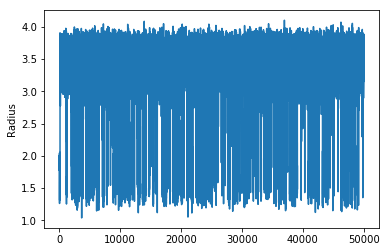

In [204]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = True

X_FT = helpers.loadData(folderName+dataName+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r)
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [174]:
def compute_free_energy(cv, weights=None, nrbins=100):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)

    return free_energy, bin_centers

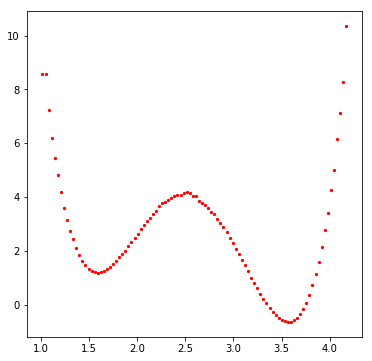

In [175]:
cv=colective_variable(X_FT)

free_energy_300_ref, bin_centers = compute_free_energy(cv, nrbins = 100)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bin_centers, free_energy_300_ref, s=5, c='r', marker='o')
plt.show()

Loaded trajectory of length 50000


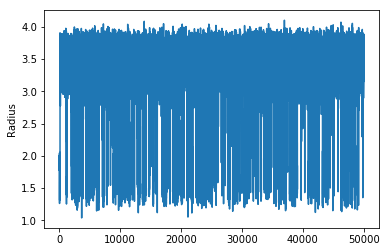

In [214]:
methodName='T500/std_500'#'frontier_points_corner'#'frontier_points_corner'#
modnr = 2
metric_choice = 'rmsd'

if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = True

X_FT = helpers.loadData(folderName+dataName+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
cv=colective_variable(X_FT)

plt.plot(range(len(r)), r)
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

Get the target density at sampled data points
... might take a while ...
Done
Done


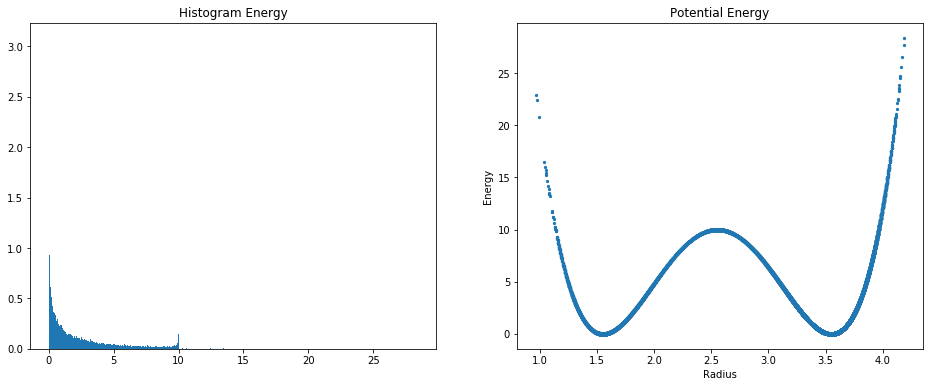

In [215]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

### Try out gaussian mixture models

In [243]:
from sklearn import mixture

Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

clf = mixture.GaussianMixture(n_components=100, covariance_type='full', n_init = 10)
clf.fit(Xresh)

q = np.exp(clf.score_samples(Xresh))

In [244]:
clf.bic(Xresh)

1136455.9964465485

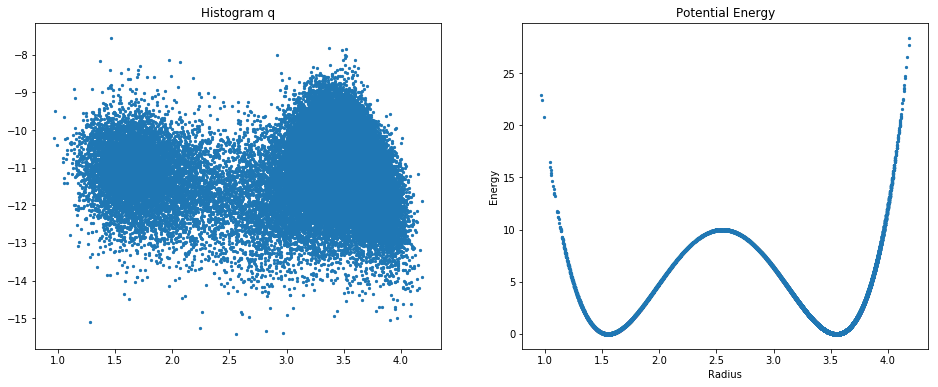

In [245]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.scatter(colective_variable(X_FT), np.log(q), s=5)
ax.set_title('Histogram q')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')
plt.show()

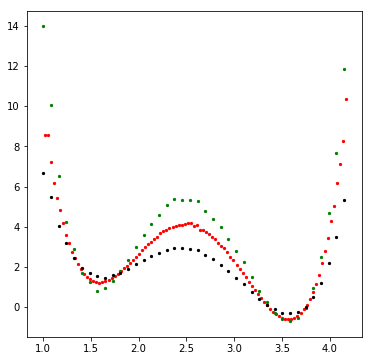

In [246]:
weight = qTargetDistribution_targetTemperature/q
#weight = qTargetDistribution/q
#weight = qT/q
cv=colective_variable(X_FT)

free_energy_unbiased, bin_centers_unb = compute_free_energy(cv, nrbins = 40, weights=weight)
free_energy_500, bin_centers_unb = compute_free_energy(cv, nrbins = 40, weights=None)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bin_centers, free_energy_300_ref, s=5, c='r', marker='o')
ax.scatter(bin_centers_unb, free_energy_unbiased, s=5, c='g', marker='o')
ax.scatter(bin_centers_unb, free_energy_500, s=5, c='k', marker='o')
plt.show()

In [79]:
smpl.model.energy(X_FT[100]) / smpl.kT

5794389.662133662

In [139]:
#qT=np.zeros(len(X_FT))

#for i in range(0,len(X_FT)):
#    qT[i] = smpl.model.energy(X_FT[i]*smpl.model.x_unit) / (2.0*smpl_target.kT)
    
#qT = np.exp(-qT)